In [1]:
from importlib.metadata import version

pkgs = [
	"numpy",       # PyTorch & TensorFlow dependency
	"matplotlib",  # Plotting library
	"tiktoken",    # Tokenizer
	"torch",       # Deep learning library
	"tqdm",        # Progress bar
	"tensorflow",  # For OpenAI's pretrained weights
]
for p in pkgs:
	print(f"{p} version: {version(p)}")

numpy version: 1.23.0
matplotlib version: 3.4.3
tiktoken version: 0.7.0
torch version: 2.4.1
tqdm version: 4.62.3
tensorflow version: 2.13.1


### 2 准备数据集

In [2]:
import json
import os
import urllib
import urllib.request

def download_and_load_file(file_path, url):
	if not os.path.exists(file_path):
		with urllib.request.urlopen(url) as response:
			text_data = response.read().decode("utf-8")
		with open(file_path, "w", encoding="utf-8") as file:
			file.write(text_data)

	with open(file_path, "r", encoding="utf-8") as file:
		data = json.load(file)
	
	return data

file_path = "instruction-data.json"
url = (
	"https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
	"/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [3]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [4]:
# "input" 可以为空
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


In [5]:
def format_input(entry):
	instruction_text = (
		f"Below is an instruction that describes a task. "
		f"Write a response that appropriately completes the request."
		f"\n\n### Instruction:\n{entry['instruction']}"
	)

	input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

	return instruction_text + input_text

In [6]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [7]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


In [8]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [9]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


### 3 Organizing data into training batches

In [10]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
	def __init__(self, data, tokenizer):
		self.data = data

		self.encoded_texts = []
		for entry in data:
			instruction_plus_input = format(entry)
			response_text = f"\n\n### Response:\n{entry['output']}"
			full_text = instruction_plus_input + response_text
			self.encoded_texts.append(tokenizer.encode(full_text))

	def __getitem__(self, index):
		return self.encoded_texts[index]
	
	def __len__(self):
		return len(self.data)

In [11]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [12]:
# each batch to have the same length (but different batches can have different lengths)
def custom_collate_draft_1(batch, pad_token_id=50256, device="cpu"):
	"""
	input
	"""
	batch_max_length = max(len(item) + 1 for item in batch)	# +1 保证所有序列末尾都有 <|endoftext|>

	inputs_lst = []
	for item in batch:
		new_item = item.copy()
		new_item += [pad_token_id]

		padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
		inputs = torch.tensor(padded[:-1])	# ques -1?
		inputs_lst.append(inputs)

	inputs_tensor = torch.stack(inputs_lst).to(device)
	return inputs_tensor	# 最终返回的长度 = batch中最长的长度

In [13]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
	inputs_1,
	inputs_2,
	inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [14]:
def custom_collate_draft_2(batch, pad_token_ids=50256, device="cpu"):
	batch_max_length = max(len(item) + 1 for item in batch)

	inputs_lst, target_lst = [], []
	for item in batch:
		new_item = item.copy()
		new_item += [pad_token_ids]
		padded = new_item + [pad_token_ids] * (batch_max_length - len(new_item))

		inputs = torch.tensor(padded[:-1])
		targets = torch.tensor(padded[1:])
		inputs_lst.append(inputs)
		target_lst.append(targets)

	inputs_tensor = torch.stack(inputs_lst).to(device)
	target_tensor = torch.stack(target_lst).to(device)
	return inputs_tensor, target_tensor

In [15]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [16]:
# 忽略多余的padding

def custom_collate_fn(batch, pad_token_id=50256, ignore_index=-100, allowed_max_length=None, device="cpu"):
	batch_max_length = max(len(item) + 1 for item in batch)

	inputs_lst, target_lst = [], []
	for item in batch:
		new_item = item.copy()
		new_item += [pad_token_id]
		padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
		inputs = torch.tensor(padded[:-1])
		targets = torch.tensor(padded[1:])

		# 只保留第一个<|endoftext|> 其他全改为-100
		mask = targets == pad_token_id
		indices = torch.nonzero(mask).squeeze()	# 获得 50256 下标
		if indices.numel() > 1:	# 多个 50256
			targets[indices[1:]] = ignore_index	# 之后全换成 -100

		# 可选择截断至最大序列长度
		if allowed_max_length is not None:
			inputs = inputs[:allowed_max_length]
			targets = targets[:allowed_max_length]

		inputs_lst.append(inputs)
		target_lst.append(targets)
	
	inputs_tensor = torch.stack(inputs_lst).to(device)
	targets_tensor = torch.stack(target_lst).to(device)

	return inputs_tensor, targets_tensor

In [17]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [18]:
logits_1 = torch.tensor(
	[[-1.0, 1.0],  # 1st training example
	[-0.5, 1.5]]  # 2nd training example
)
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [19]:
logits_2 = torch.tensor(
	[[-1.0, 1.0],
	 [-0.5, 1.5],
	 [-0.5, 1.5]]  # New 3rd training example
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


In [20]:
# 将3 换成 -100
targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)	# cross_entropy 中 的ignore_index默认=-100
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


###  4 datdaloader

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [22]:
from functools import partial

customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)	# 参数预填充pre-filled	# curring!!!

In [23]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)
train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
	train_dataset,
	batch_size=batch_size,
	collate_fn=customized_collate_fn,
	shuffle=True,
	drop_last=True,
	num_workers=num_workers
)

In [24]:
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
	val_dataset,
	batch_size=batch_size,
	collate_fn=customized_collate_fn,
	shuffle=False,
	drop_last=False,
	num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
	test_dataset,
	batch_size=batch_size,
	collate_fn=customized_collate_fn,
	shuffle=False,
	drop_last=False,
	num_workers=num_workers
)

In [25]:
print("Train loader:")
for inputs, targets in train_loader:
	print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 108]) torch.Size([8, 108])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 95]) torch.Size([8, 95])
torch.Size([8, 90]) torch.Size([8, 90])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 59]) torch.Size([8, 59])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 107]) torch.Size([8, 107])
torch.Size([8, 89]) torch.Size([8, 89])
torch.Size([8, 102]) torch.Size([8, 102])
torch.Size([8, 92]) torch.Size([8, 92])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 118]) torch.Size([8, 118])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 112]) torch.Size([8, 112])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 8

In [26]:
print(inputs[0])
print(targets[0])

tensor([   90,     6,  8625,  2762, 10354,   705, 30003,  6525,   262,  6827,
         1262,   257,   985,   576,  2637,    11,   705, 15414, 10354,   705,
          464,  5156,   318,   845, 13779,  2637,    11,   705, 22915, 10354,
          705,   464,  5156,   318,   355, 13779,   355,   257,  4936,  2637,
           92,   198,   198, 21017, 18261,    25,   198,   464,  5156,   318,
          355, 13779,   355,   257,  4936,    13, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256], device='cuda:0')
tensor([    6,  8625,  2762, 10354,   705, 30003,  6525,   262,  6827,  1262,
          257,   985,   576,  2637,    11,   705, 15414, 10354,   705,   464,
         5156,   318,   845, 13779,  2637,    11,   705, 22915, 10354,   705,
          464,  5156,   318,   355, 13779,   355,   257,  4936,  2637,    92,
          198,   198, 21017, 18261,    25,   198,   464,  5156,   318,   355,
        13779,   355,   

### 5 Loading a pretrained LLM

In [27]:
import sys
sys.path.append("../ch05")

from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt

BASE_CONFIG = {
	"vocab_size": 50257,     # Vocabulary size
	"context_length": 1024,  # Context length
	"drop_rate": 0.0,        # Dropout rate
	"qkv_bias": True         # Query-key-value bias
}

model_configs = {
	"gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
	"gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
	"gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
	"gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
setting, params = download_and_load_gpt2(model_size=model_size, models_dir="../ch05/gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

2025-07-18 08:29:11.950745: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-18 08:29:11.996110: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


File already exists and is up-to-date: ../ch05/gpt2/355M/checkpoint
File already exists and is up-to-date: ../ch05/gpt2/355M/encoder.json
File already exists and is up-to-date: ../ch05/gpt2/355M/hparams.json
File already exists and is up-to-date: ../ch05/gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: ../ch05/gpt2/355M/model.ckpt.index
File already exists and is up-to-date: ../ch05/gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: ../ch05/gpt2/355M/vocab.bpe


In [28]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)
# Convert the active sentence to passive: 'The chef cooks the meal every day.'

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [29]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [30]:
# 只能重复回答
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


### 6 Finetuning the LLM on instruction data

In [31]:
from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)

In [32]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 2.891008424758911
Validation loss: 2.7637264251708986


In [33]:
import time
start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 2
train_losses, val_losses, token_seen = train_model_simple(
	model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq=5, eval_iter=5,
	start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.107, Val loss 2.012
Ep 1 (Step 000005): Train loss 1.085, Val loss 0.988
Ep 1 (Step 000010): Train loss 0.790, Val loss 0.887
Ep 1 (Step 000015): Train loss 0.827, Val loss 0.859
Ep 1 (Step 000020): Train loss 0.714, Val loss 0.841
Ep 1 (Step 000025): Train loss 0.706, Val loss 0.808
Ep 1 (Step 000030): Train loss 0.773, Val loss 0.794
Ep 1 (Step 000035): Train loss 0.698, Val loss 0.769
Ep 1 (Step 000040): Train loss 0.673, Val loss 0.766
Ep 1 (Step 000045): Train loss 0.621, Val loss 0.754
Ep 1 (Step 000050): Train loss 0.632, Val loss 0.738
Ep 1 (Step 000055): Train loss 0.705, Val loss 0.721
Ep 1 (Step 000060): Train loss 0.706, Val loss 0.708
Ep 1 (Step 000065): Train loss 0.624, Val loss 0.697
Ep 1 (Step 000070): Train loss 0.520, Val loss 0.694
Ep 1 (Step 000075): Train loss 0.542, Val loss 0.698
Ep 1 (Step 000080): Train loss 0.586, Val loss 0.681
Ep 1 (Step 000085): Train loss 0.487, Val loss 0.666
Ep 1 (Step 000090): Train loss 0.520, Val loss

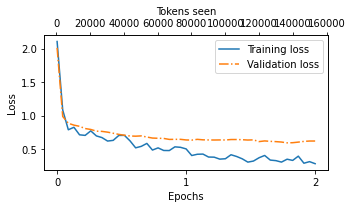

In [34]:
from previous_chapters import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, token_seen, train_losses, val_losses)

### 7 Extracting and saving responses

In [35]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.
The car is as fast as a cheetah.
The car is as fast as a cheetah.
The car is as fast as a cheetah.
The car is as fast as a cheetah.
The car is as fast as a cheetah.
The car is as fast as a cheetah.
The car is as fast as a cheetah.
The car is as fast as a cheetah.
The car is as fast as a cheetah.
The car is as fast as a cheetah.
The car is as fast as a cheetah.
The car is as fast as a cheetah.
The car is as fast as a cheetah.
The car is as fast as a cheetah.
The car is as fast as a cheetah.
The car is as fast as a cheetah.
The car is as fast as a cheetah.
The car is as fast as a cheetah.
The car is as fast as a cheetah.
The car is as fast as a cheetah.
The car is
--------------------------

In [37]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
	input_text = format_input(entry)

	token_ids = generate(
		model=model,
		idx=text_to_token_ids(input_text, tokenizer).to(device),
		max_new_tokens=256,
		context_size=BASE_CONFIG["context_length"],
		eos_id=50256
	)
	generated_text = token_ids_to_text(token_ids, tokenizer)
	response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

	test_data[i]["model_response"] = response_text

with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|██████████| 110/110 [00:44<00:00,  2.49it/s]


In [38]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a cheetah.\nThe car is as fast as a cheetah.\nThe car is as fast as a cheetah.\nThe car is as fast as a cheetah.\nThe car is as fast as a cheetah.\nThe car is as fast as a cheetah.\nThe car is as fast as a cheetah.\nThe car is as fast as a cheetah.\nThe car is as fast as a cheetah.\nThe car is as fast as a cheetah.\nThe car is as fast as a cheetah.\nThe car is as fast as a cheetah.\nThe car is as fast as a cheetah.\nThe car is as fast as a cheetah.\nThe car is as fast as a cheetah.\nThe car is as fast as a cheetah.\nThe car is as fast as a cheetah.\nThe car is as fast as a cheetah.\nThe car is as fast as a cheetah.\nThe car is as fast as a cheetah.\nThe car is as fast as a cheetah.\nThe car is'}


In [41]:
# 保存模型

import re
file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL)}-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-medium355M-sft.pth


In [ ]:
### 8 Evaluating